In [1]:
from edc import check_compatibility
check_compatibility("user-2022.10-14", dependencies=[])

# Earth System Data Lab Tutorial @ Euro Data Cube 
## Brought to you by Brockmann Consult

The Earth System Data Cube is a collection of pre-generated data cubes with geophysical, biogeochemical, and ecological variables relevant for Earth System Sciences. These data sets are open and free and thus also available also through EDC. This notebook demonstrates access to the ESDC data sets. 

## Import packages

Due to memory problems with dask versions greater than 2021.03.1 as described in issue https://github.com/dask/dask/issues/7583 it is necessary to use dask distributed client. We also import 'progress' to visualize the computing time. 

In [2]:
from dask.distributed import Client, progress

In [3]:
client = Client()

In [4]:
client.current()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38867,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:39355,Total threads: 1
Dashboard: http://127.0.0.1:35187/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:44445,


In [5]:
#client.close()

In [6]:
from xcube.core.store import new_data_store
import xarray as xr

# utilities
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Data Access

In [7]:
root = "esdl-esdc-v2.1.1"

In [8]:
data_store = new_data_store("s3", 
                            root=root, 
                            storage_options=dict(anon=True)
                           ) 

In [9]:
list(data_store.get_data_ids())


['esdc-8d-0.083deg-184x270x270-2.1.1.zarr',
 'esdc-8d-0.083deg-1x2160x4320-2.1.1.zarr',
 'esdc-8d-0.25deg-184x90x90-2.1.1.zarr',
 'esdc-8d-0.25deg-1x720x1440-2.1.1.zarr']

In [10]:
ESDC_hi = data_store.open_data("esdc-8d-0.083deg-1x2160x4320-2.1.1.zarr")

In [11]:
ESDC_hi.land_surface_temperature

<xarray.DataArray 'land_surface_temperature' (time: 1840, lat: 2160, lon: 4320)>
dask.array<open_dataset-b7f944453e47fdc2146ca4ffff40db41land_surface_temperature, shape=(1840, 2160, 4320), dtype=float32, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 1979-01-05 1979-01-13 ... 2018-12-31
Attributes:
    ID:                        69
    esa_cci_path:              nan
    long_name:                 Land Surface Temperature
    orig_version:              nan
    project_name:              GlobTemperature
    time_coverage_end:         2011-12-31
    time_coverage_resolution:  P8D
    time_coverage_start:       2002-05-21
    units:                     K
    url:                       http://data.globtemperature.info/

In [12]:
ESDC_hi.land_surface_temperature.attrs

{'ID': 69,
 'esa_cci_path': nan,
 'long_name': 'Land Surface Temperature',
 'orig_version': nan,
 'project_name': 'GlobTemperature',
 'time_coverage_end': '2011-12-31',
 'time_coverage_resolution': 'P8D',
 'time_coverage_start': '2002-05-21',
 'units': 'K',
 'url': 'http://data.globtemperature.info/'}

# Basic plotting

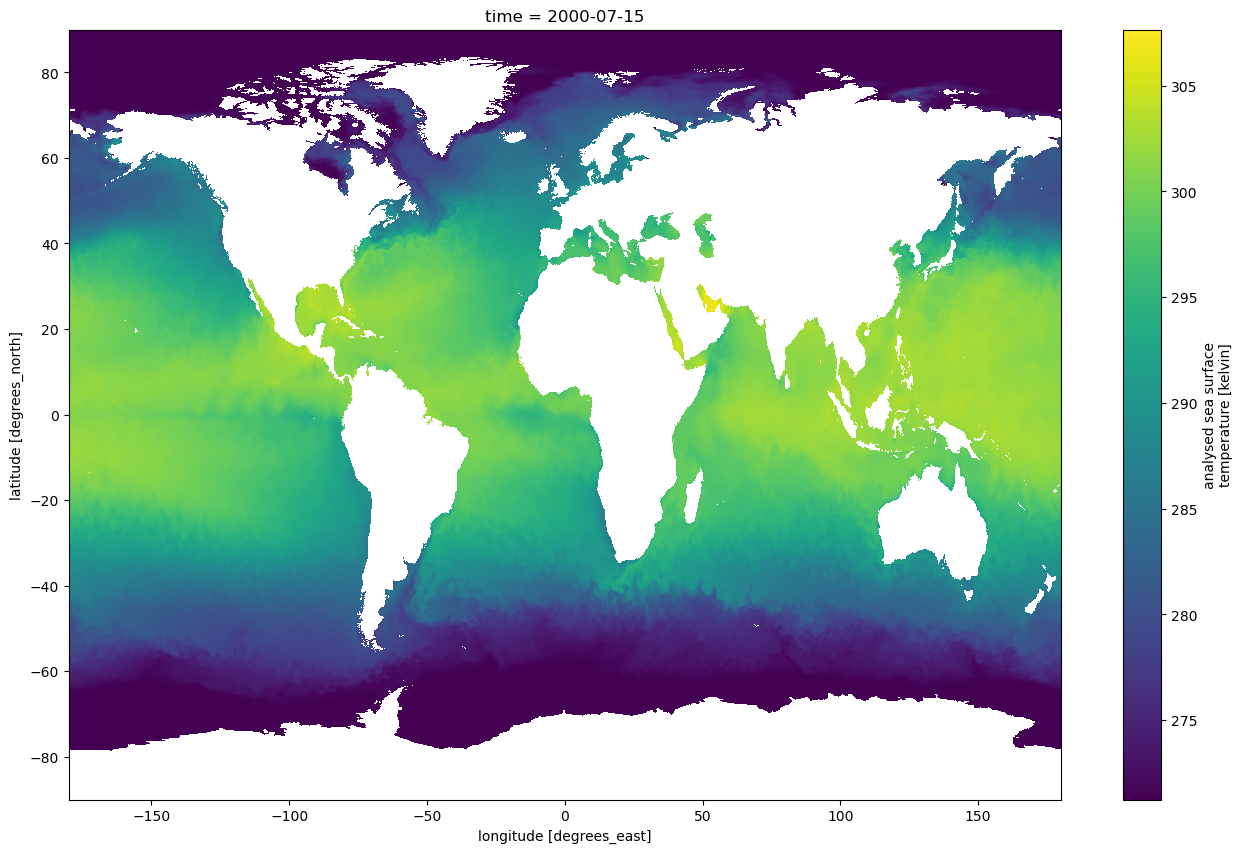

In [13]:
ESDC_hi.analysed_sst.sel(time='2000-07-15', method='nearest').plot.pcolormesh(figsize=(16,10))

In [14]:
var_names = []
for var_name in ESDC_hi.data_vars:
    var_names.append(var_name)
    
def plot_image(time_index=1400, variable_name=var_names[5]):
    ESDC_hi[variable_name][time_index].plot(figsize=(18,9), aspect='auto')

In [15]:
interact(plot_image, time_index=(0,ESDC_hi.time.size - 1,1), variable_name=var_names)

interactive(children=(IntSlider(value=1400, description='time_index', max=1839), Dropdown(description='variabl…

<function __main__.plot_image(time_index=1400, variable_name='air_temperature_2m')>

# Computation
## xarray API

In [16]:
ESDC_low_time_opt = data_store.open_data("esdc-8d-0.25deg-184x90x90-2.1.1.zarr")

In [17]:
CFC_globalmean = ESDC_low_time_opt.cfc.mean(dim='time').persist() # start computation in the background

In [18]:
progress(CFC_globalmean)      # watch progress

VBox()

In [19]:
CFC_globalmean

<xarray.DataArray 'cfc' (lat: 720, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float32, chunksize=(90, 90), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

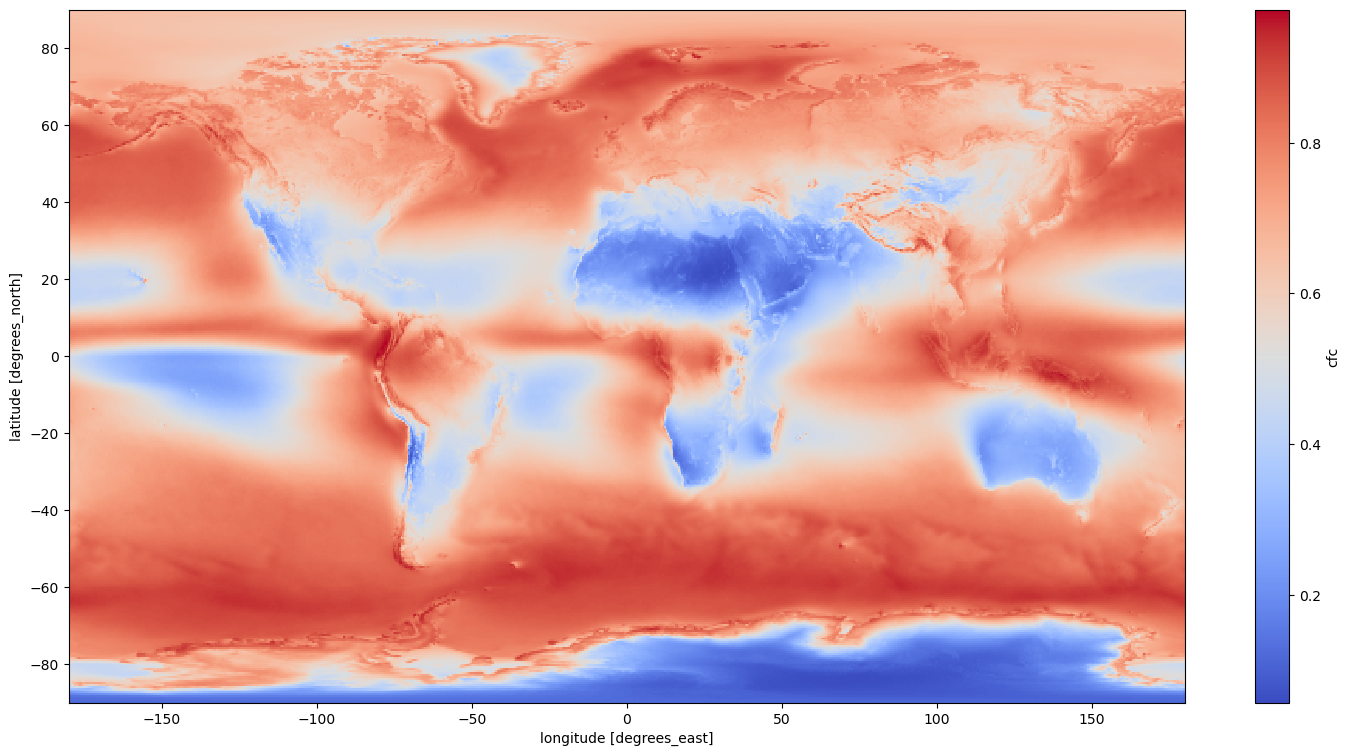

In [20]:
CFC_globalmean.plot.imshow(figsize=(18,9), cmap = "coolwarm")

In [21]:
CFC_globalmean.close()
ESDC_low_time_opt.close()

# Resampling

In [22]:
ESDC_low = data_store.open_data("esdc-8d-0.25deg-1x720x1440-2.1.1.zarr")

In [23]:
precip_monthly = ESDC_low.precipitation.resample(time = '1M',keep_attrs = True).sum('time')
precip_monthly = precip_monthly.sel(time=slice('2000-07-01', '2010-12-31'))

In [24]:
precip_monthly_rechunked = precip_monthly.chunk({'lat': 120, 'lon': 120,'time': 240}).persist()

In [25]:
progress(precip_monthly_rechunked)

VBox()

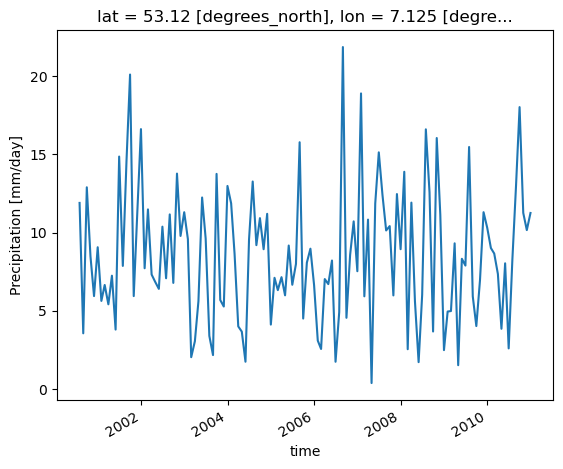

In [26]:
precip_monthly_rechunked.sel(lat=53,lon=7., method='nearest').plot()

In [27]:
precip_3month = precip_monthly_rechunked.rolling(time=3,min_periods=1, center=True).mean(skipna=True).persist()

In [28]:
progress(precip_3month)

VBox()

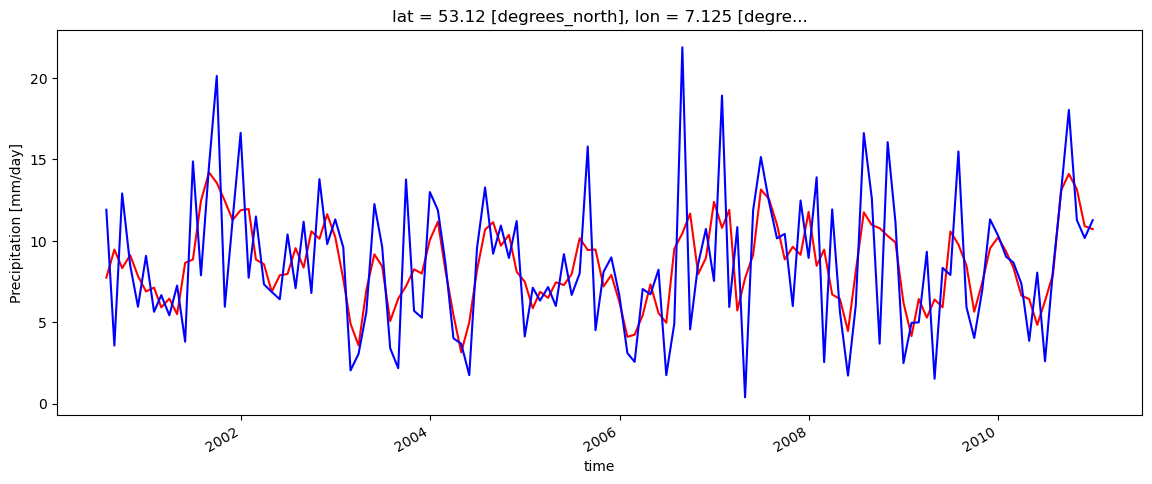

In [29]:
fig, ax = plt.subplots(figsize = [14,5], ncols=1)
precip_3month.sel(lat=53,lon=7., method='nearest').plot(ax=ax, color = 'red')
precip_monthly_rechunked.sel(lat=53,lon=7., method='nearest').plot(ax=ax, color = 'blue')

# Own functions

For the following functions it is good to use the time optimized data cube again, that's why ESDC_low_time_opt is used.

In [30]:
Europe = ESDC_low_time_opt.sel(lat = slice(70.,30.), lon = slice(-20.,30.))

In [31]:
Europe_zscore = ((Europe-Europe.mean(dim='time'))/Europe.std(dim='time'))


In [32]:
ESRIN_zscore = Europe_zscore.sel(lon = 12.67,lat = 41.83, method = 'nearest')


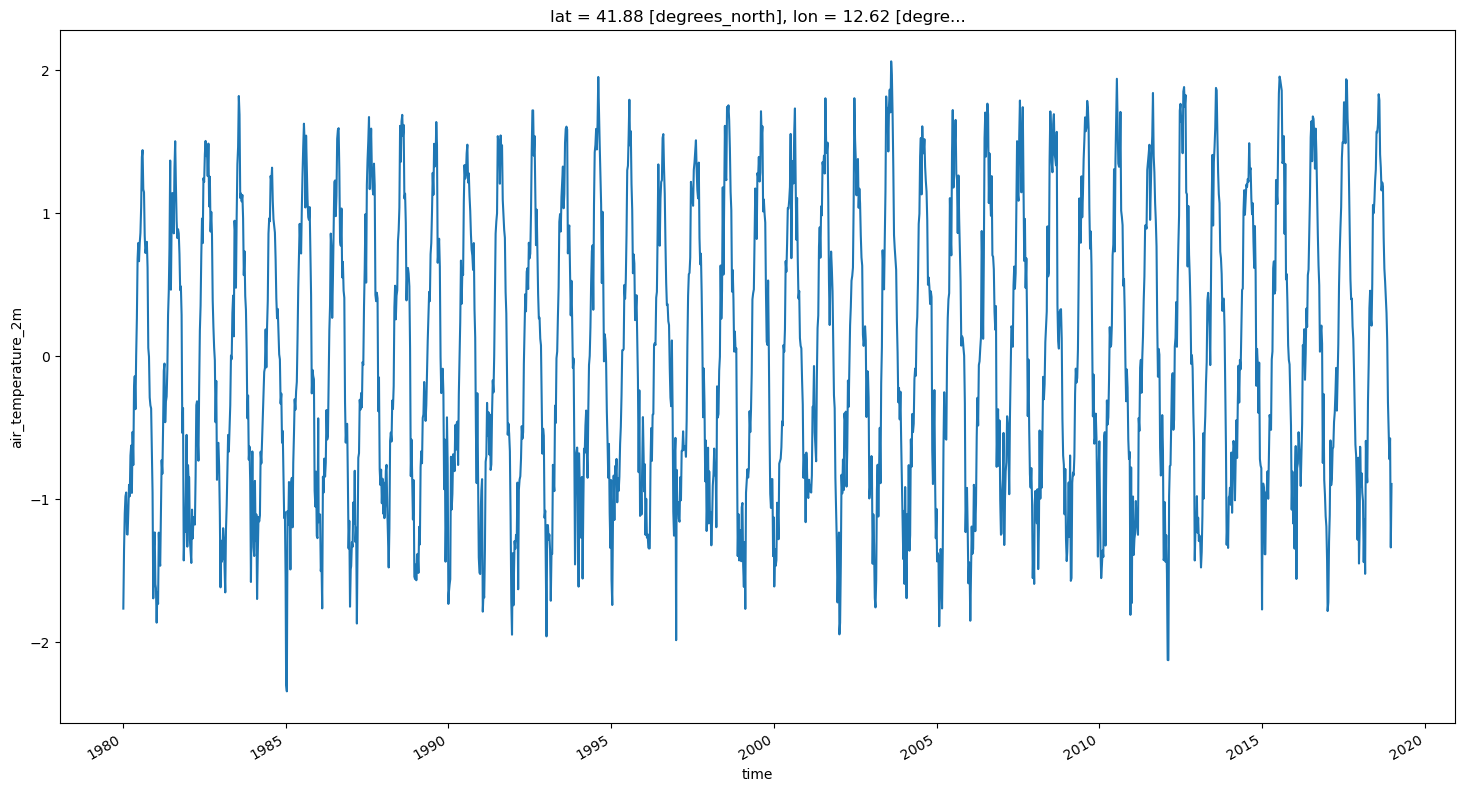

In [33]:
ESRIN_zscore.air_temperature_2m.plot(figsize=(18,9))

In [34]:
import numpy as np

In [35]:
def above_Nsigma(x,Nsigma):
    return np.fabs(x)>Nsigma

In [36]:
res = Europe_zscore.apply(above_Nsigma,Nsigma = 2)

In [37]:
air_temp_sum = res.air_temperature_2m.sum(dim="time").persist()

In [38]:
progress(air_temp_sum)

VBox()

In [39]:
evap = res.evaporation.sum(dim="time").persist()

In [40]:
progress(evap)

VBox()

/opt/conda/envs/edc-default-2022.10-14/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


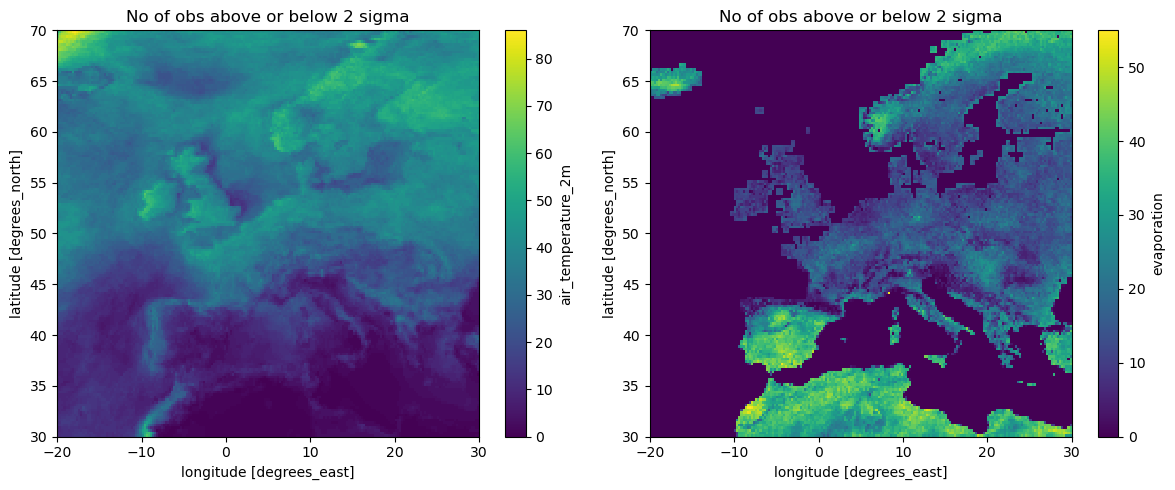

In [41]:
fig2, ax2 = plt.subplots(figsize = [12,5], ncols=2)

air_temp_sum.plot(ax = ax2[0])
ax2[0].set_title("No of obs above or below 2 sigma")

evap.plot(ax = ax2[1])
ax2[1].set_title("No of obs above or below 2 sigma")

plt.tight_layout()